## Import your stuff

In [1]:
import sys
sys.path.append('/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi')

import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import ndes as ndes
import delfi as delfi
import score as score
import priors as priors
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(6)])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_mades=5, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])]

## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher",
                            save=True,
                            restore_filename="restore")

## Fisher pre-training to initialize the NDEs

Training terminated early at epoch 167.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


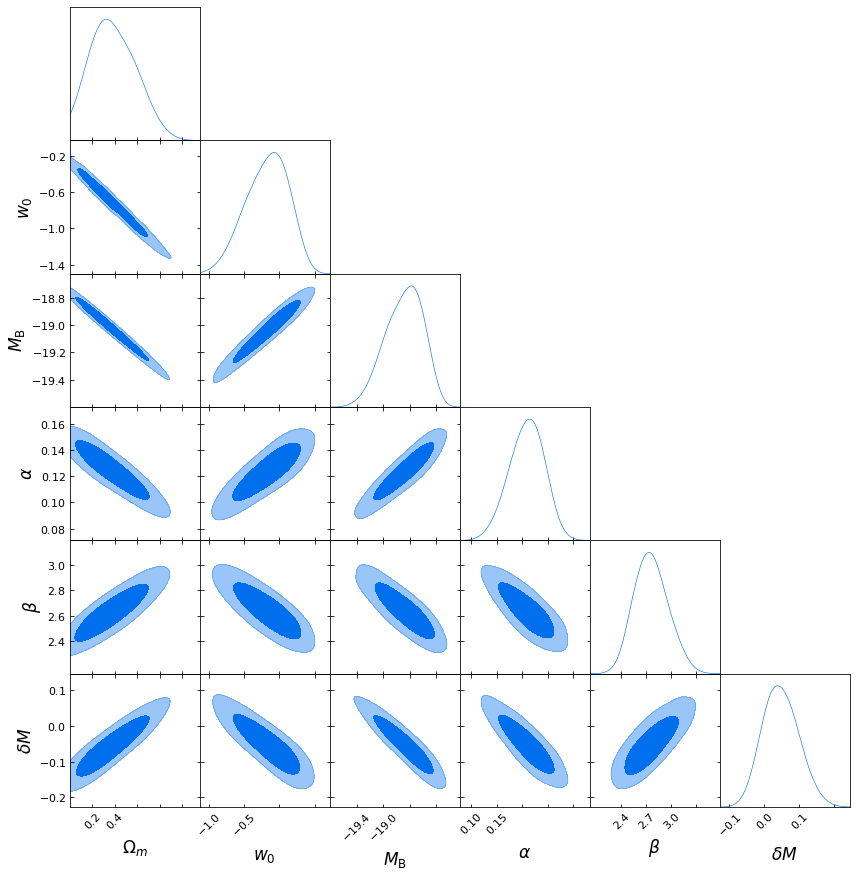

In [8]:
DelfiEnsemble.fisher_pretraining(mode="samples")

## Sequential Neural Likelihood

Training terminated early at epoch 96.
Sampling approximate posterior...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


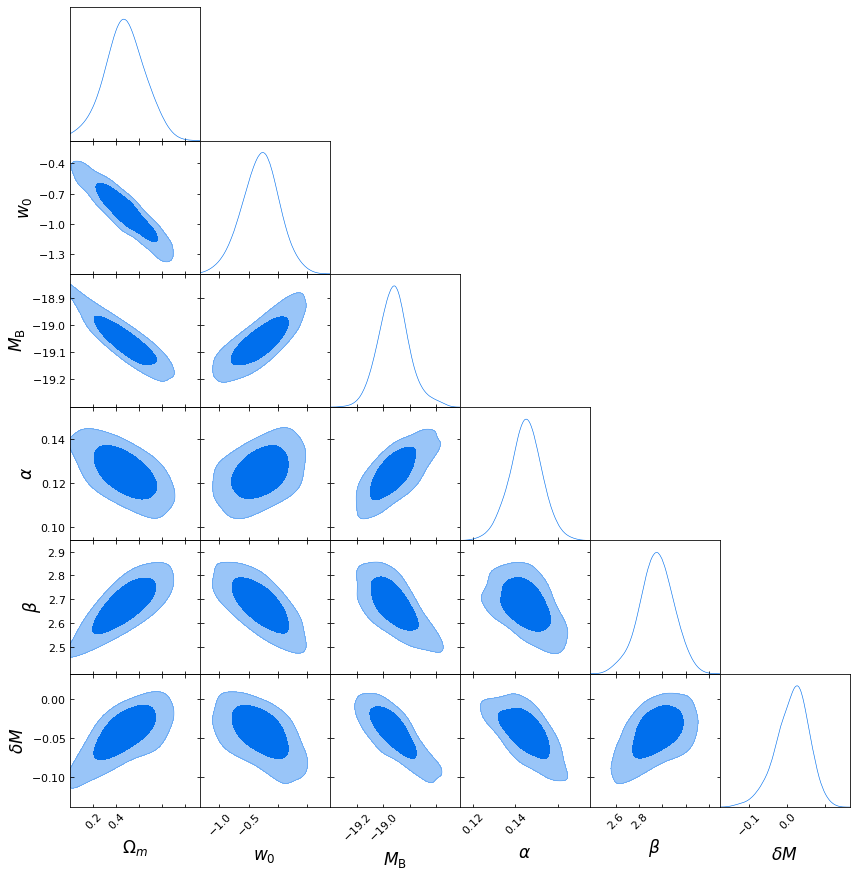

Population 1/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 71.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


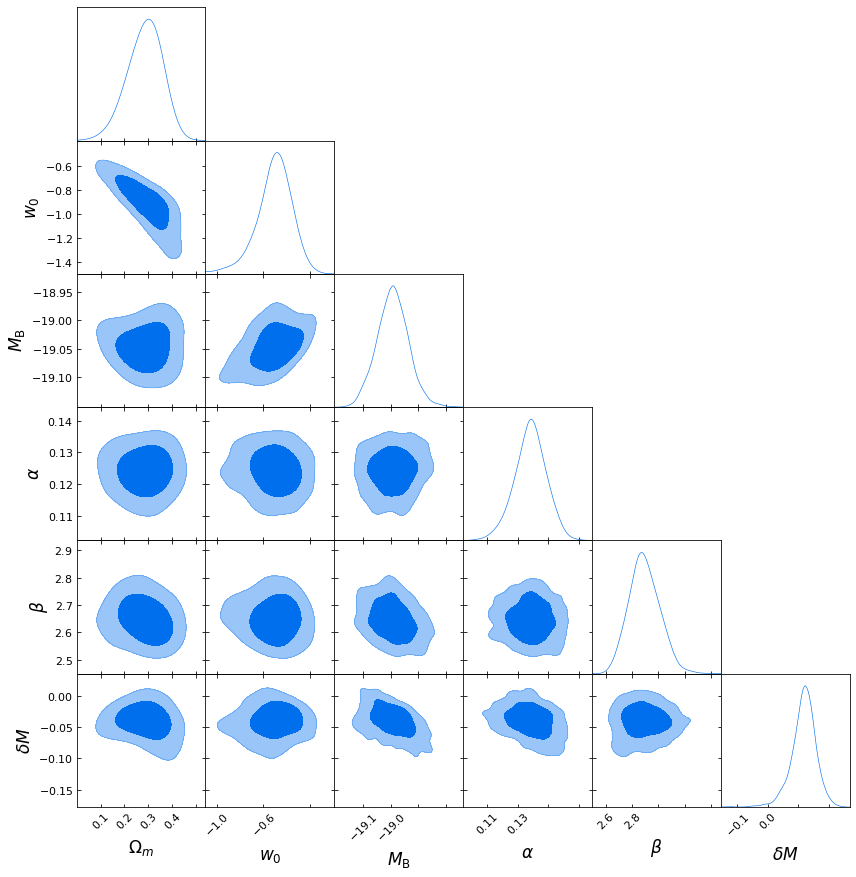

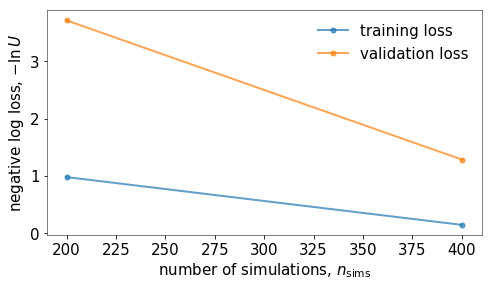

Population 2/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Training terminated early at epoch 29.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


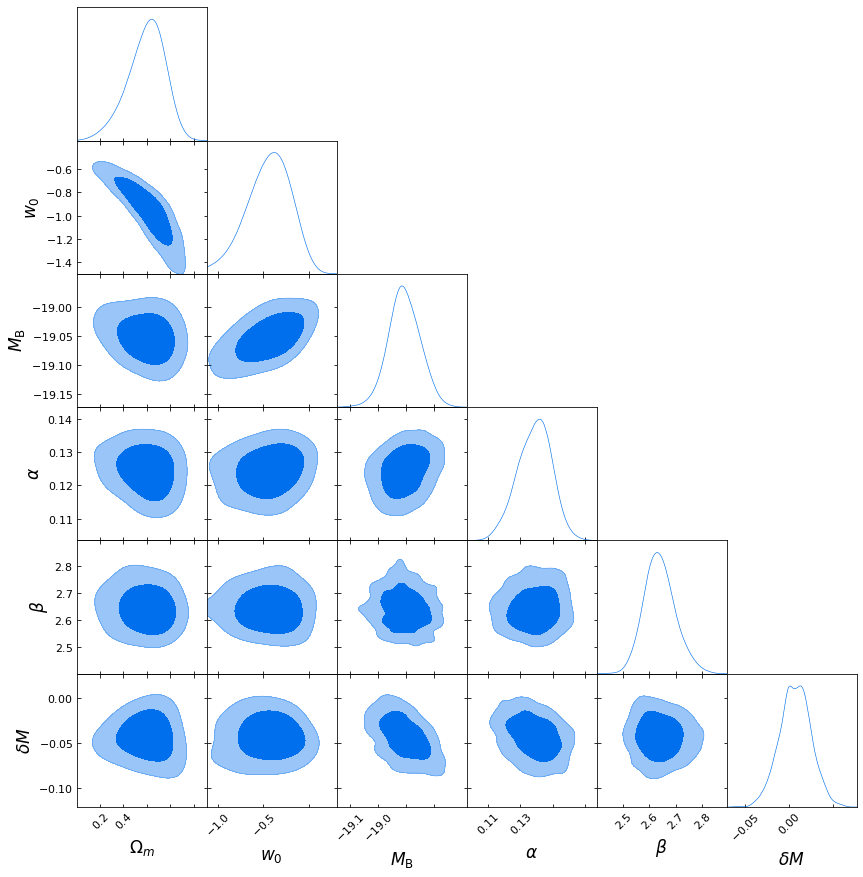

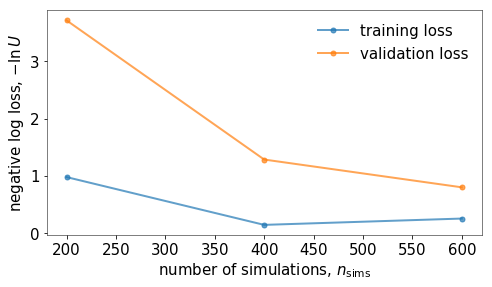

Population 3/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 34.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


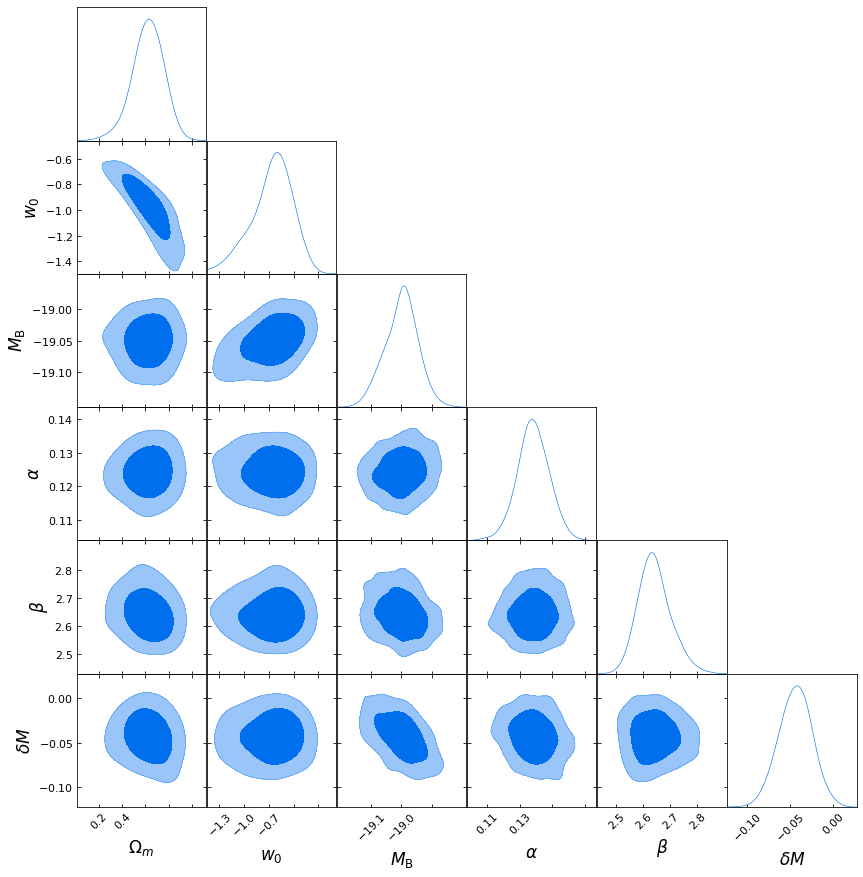

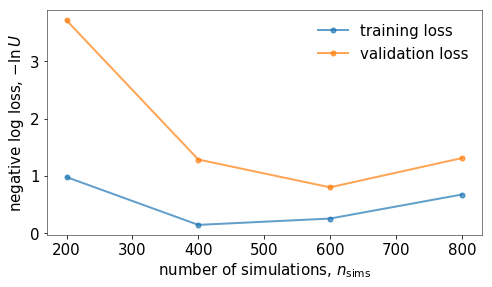

Population 4/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 21.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


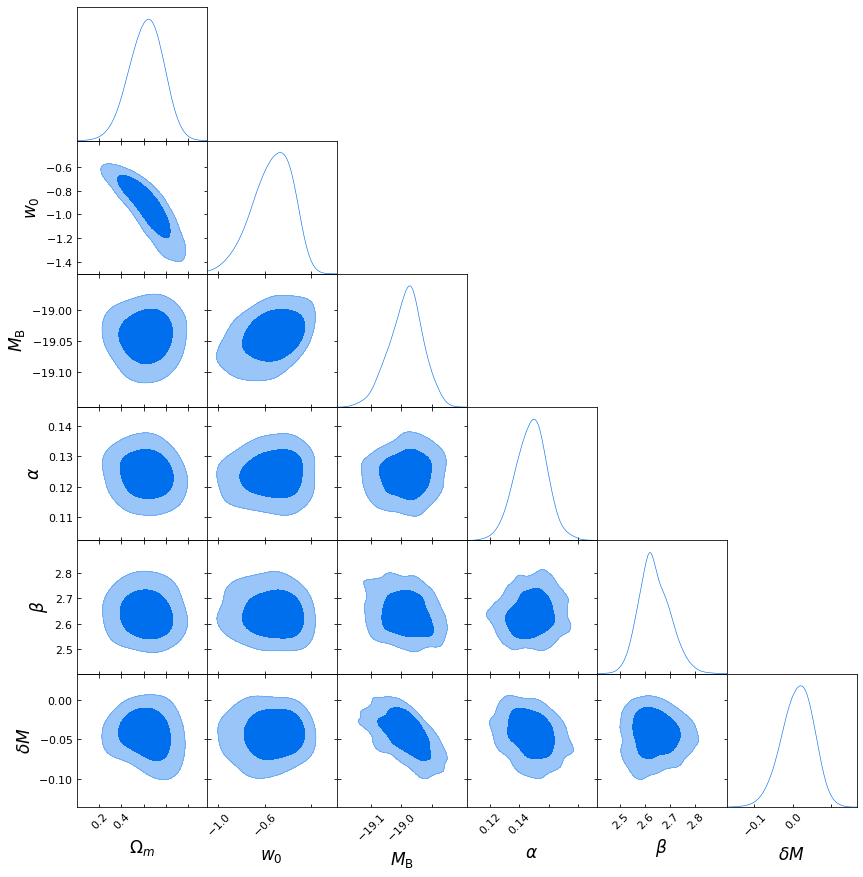

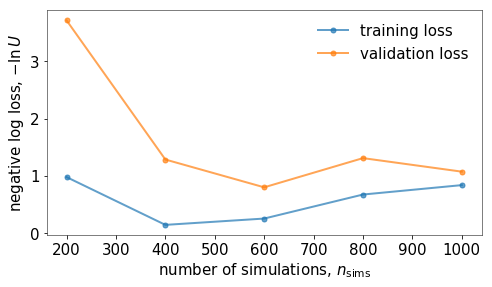

Population 5/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 20.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


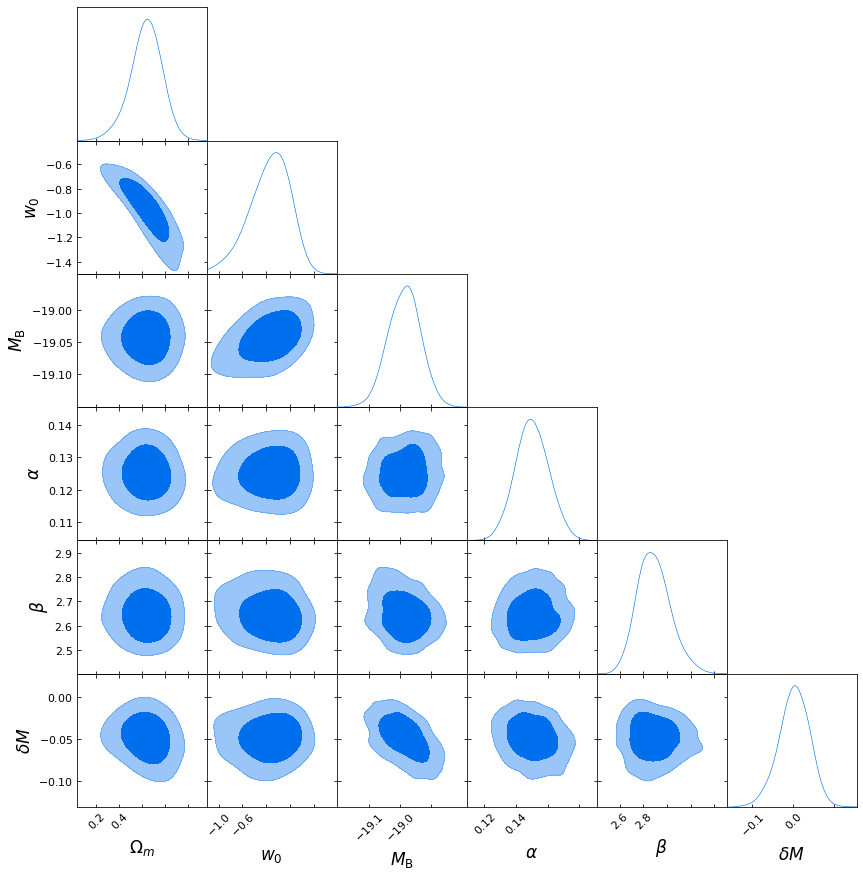

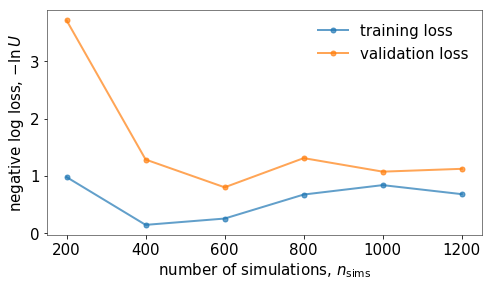

Population 6/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 20.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


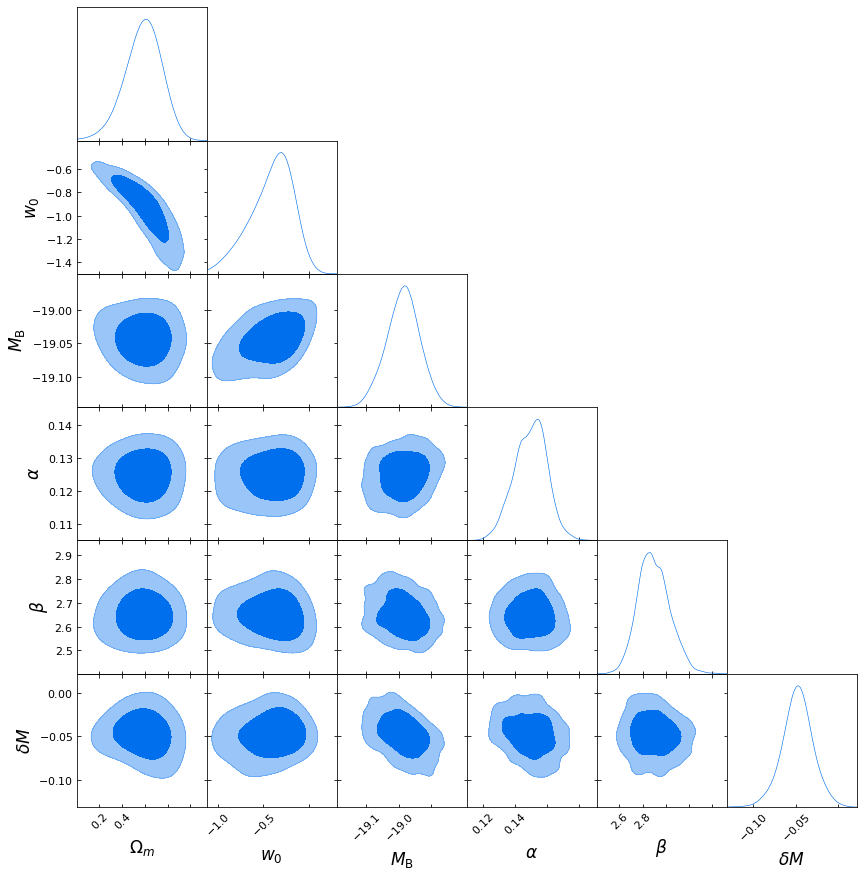

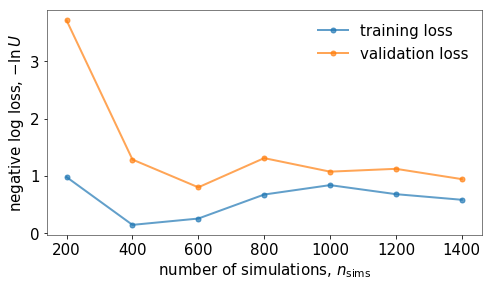

Population 7/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 31.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


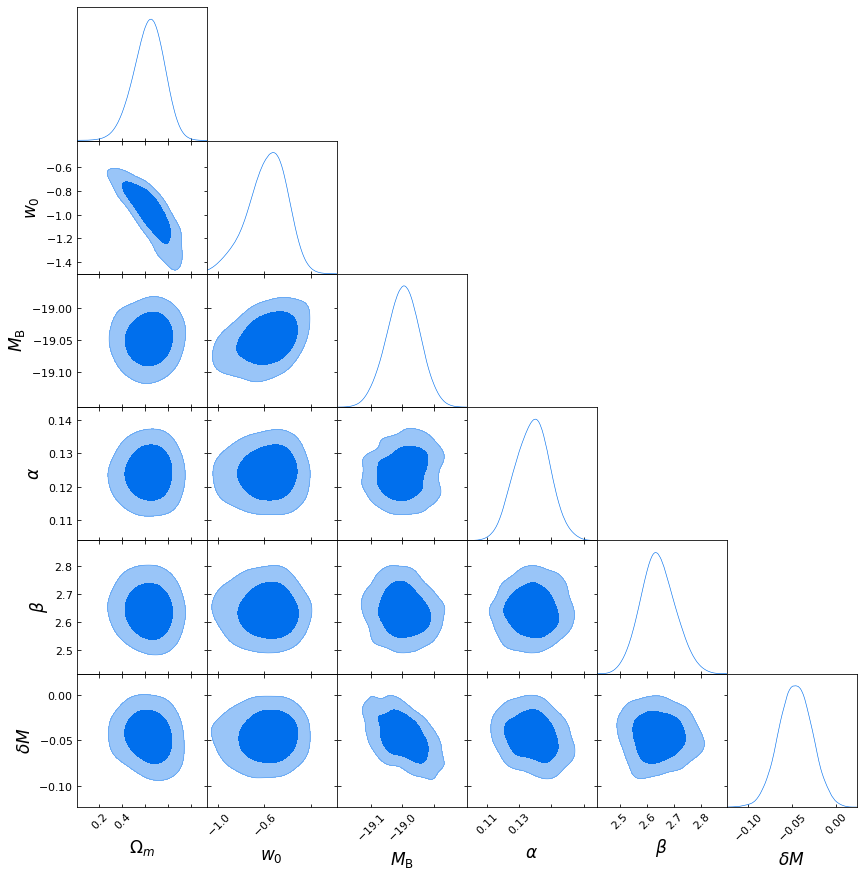

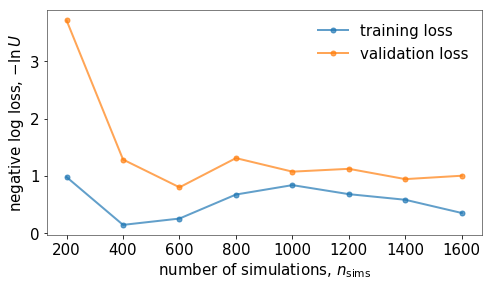

Population 8/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 23.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


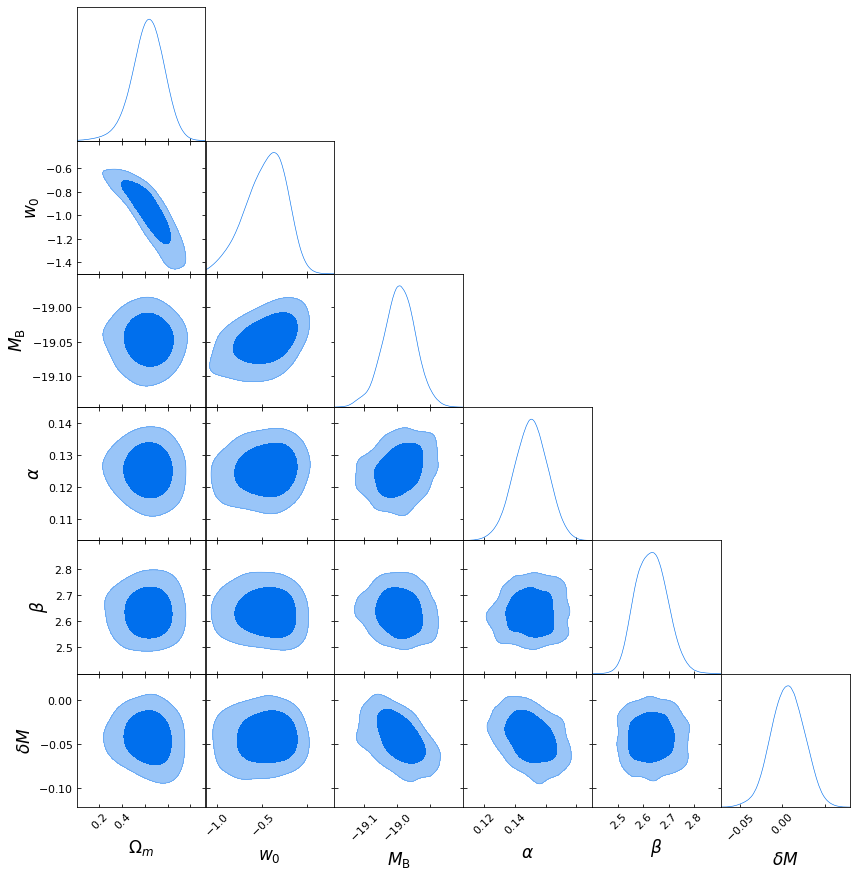

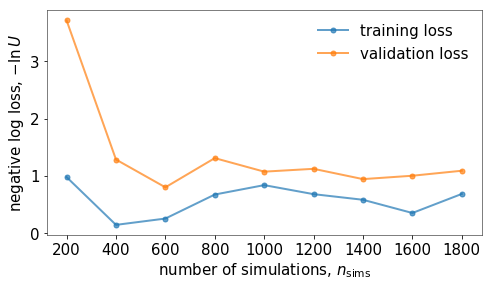

Population 9/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 24.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


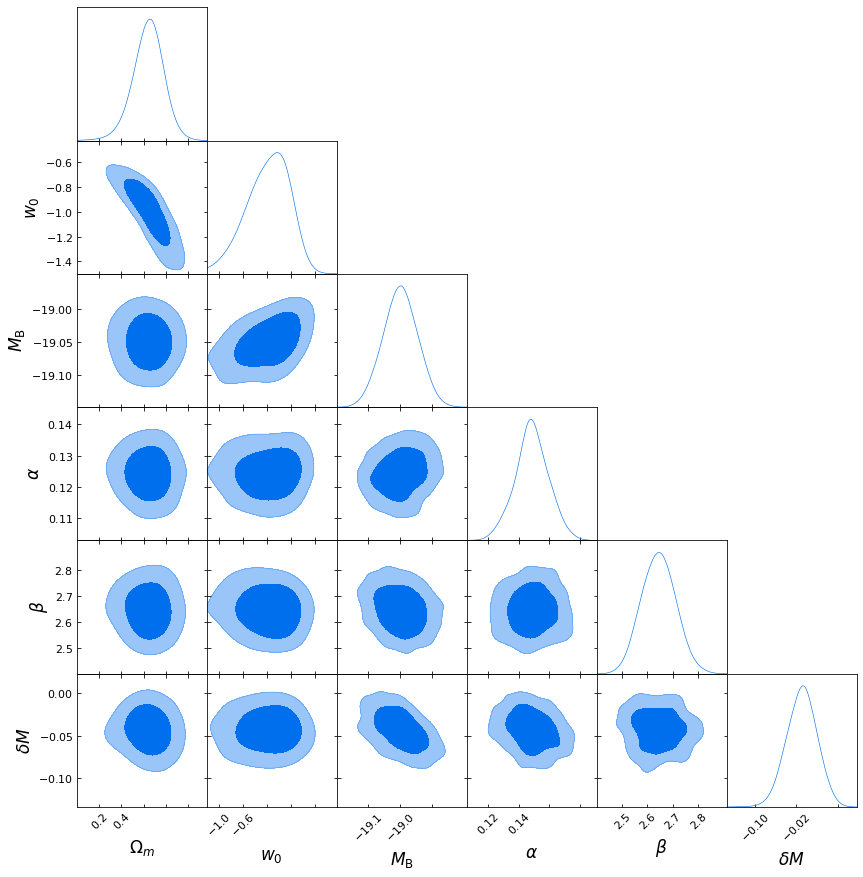

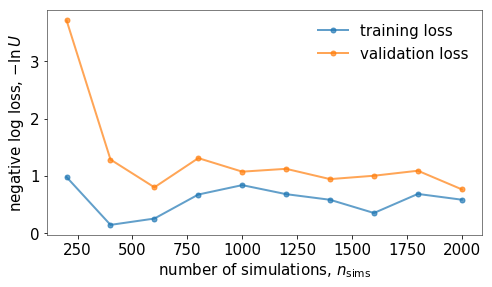

Population 10/10
Sampling proposal density...


/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi/delfi.py:226: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


Training terminated early at epoch 20.
Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


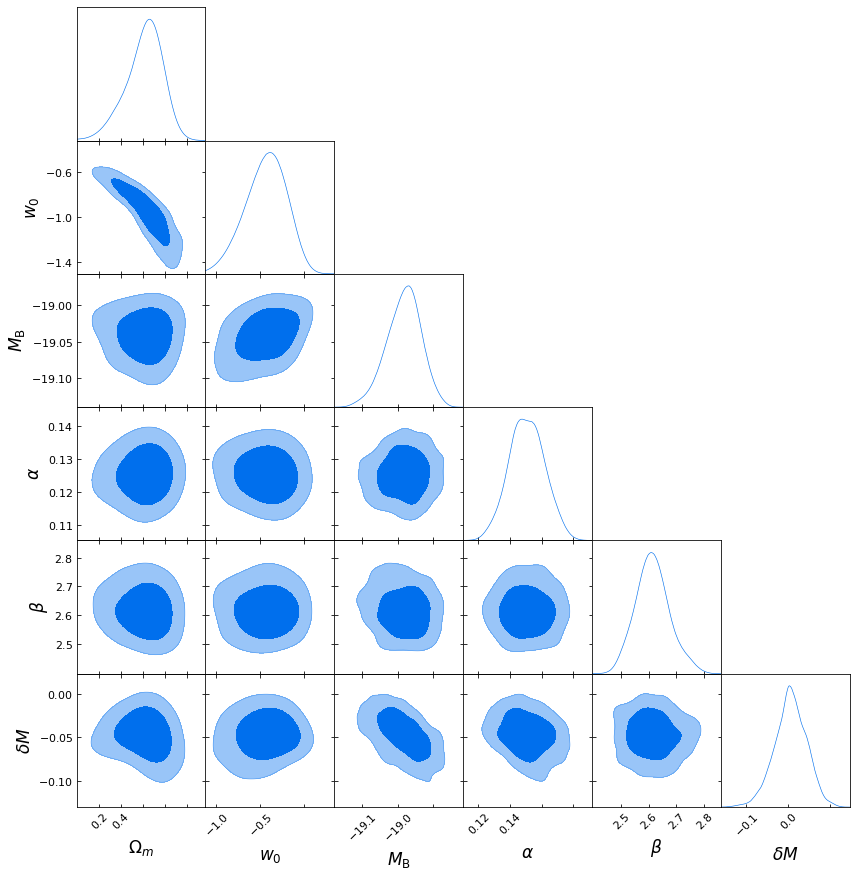

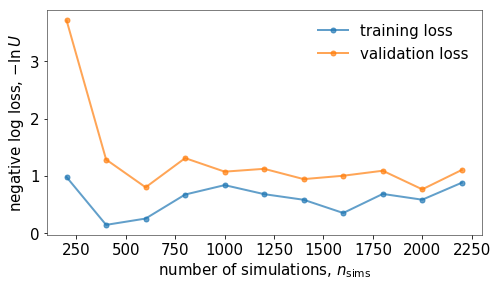

In [9]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=True)

## Sample the learned posterior

In [11]:
posterior_samples, posterior_weights, log_posterior_density = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


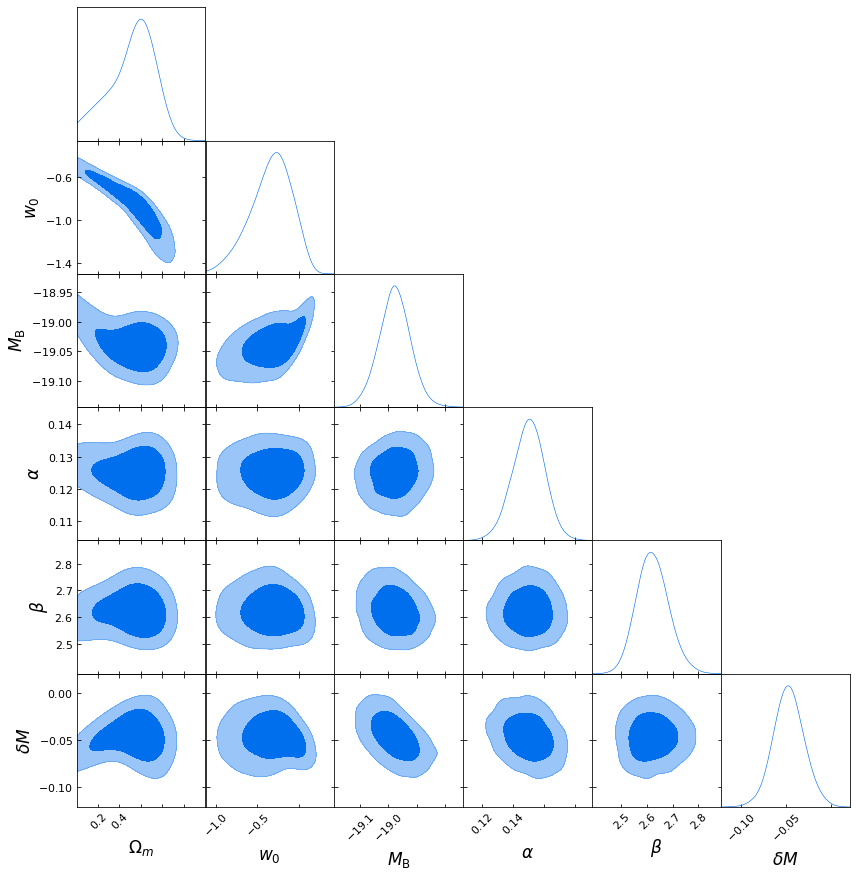

In [12]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])